In [1]:
#Librerías
import ee #earthengine
import geemap #Alternativa a GEE paquete
import matplotlib.pyplot as plt #Generación de gráficos
import seaborn as sns
import pandas as pd
import numpy as np
import os

In [2]:
#ee.Authenticate()

# <font color=rgb(135,206,235)> Inicialización y cargar visor </font>

In [3]:
ee.Initialize()

In [4]:
Map = geemap.Map()

In [5]:
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

# <font color=rgb(135,206,235)> Cargar región de interés </font>

In [6]:
AOI ='shape/AltoPatia.shp'

In [7]:
AOI = geemap.shp_to_ee(AOI)

In [8]:
Map.center_object(AOI, 12)
#Map.set_center(AOI, 12)

# <font color=rgb(135,206,235)> Cargar colecciones </font>

In [9]:
LS4 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2") #Landsat 4

In [10]:
LS5 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2") #Landsat 5

In [11]:
LS7 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2") #Landsat 7

In [12]:
LS8 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") #Landsat 8

In [13]:
MODIS = ee.ImageCollection("MODIS/061/MOD13A1")

In [14]:
DEM = ee.Image("CGIAR/SRTM90_V4") #90M

## <font color="skyblue"> Funciones para enmascarar nubes </font>

In [15]:
# Enmascarar Nubes

In [16]:
def maskL457sr(img): #Enmascara nubes de LS 4,5 y 7
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 4)
    qa = img.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return img.updateMask(mask)

In [17]:
def maskL8sr(img):
    cloudShadowBitMask = (1 << 3)
    cloudsBitMask = (1 << 4)
    qa = img.select('QA_PIXEL')
    mask = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(qa.bitwiseAnd(cloudsBitMask).eq(0))
    return img.updateMask(mask)

## <font color="skyblue">Filtrar imagenes </font>

In [18]:
#Filtrar imagenes

In [19]:
LS5 = LS5.filterDate('1985-01-01', '2010-12-31').filterBounds(AOI).filter(ee.Filter.lt('CLOUD_COVER', 30)).map(maskL457sr)

In [20]:
LS7 = LS7.filterDate('2011-01-01', '2013-12-31').filterBounds(AOI).filter(ee.Filter.lt('CLOUD_COVER', 30)).map(maskL457sr)

In [21]:
LS8 = LS8.filterDate('2014-01-01', '2022-12-31').filterBounds(AOI).filter(ee.Filter.lt('CLOUD_COVER', 30)).map(maskL8sr)

## <font color="skyblue"> Funciones para estimar NDVI </font>

$
NDVI = \frac{NIR-RED}{NIR+RED}
$

In [22]:
def toNDVI457(img):
    ndvi = img.expression('((NIR - RED) / (NIR + RED))',
    {'NIR': img.select('SR_B4'),
    'RED': img.select('SR_B3')}).rename('NDVI').copyProperties(img, ['system:time_start'])
    return img.addBands(ndvi)

In [23]:
def toNDVI8(img):
    ndvi = img.expression('((NIR - RED) / (NIR + RED))',
    {'NIR': img.select('SR_B5'),
    'RED': img.select('SR_B4')}).rename('NDVI').copyProperties(img, ['system:time_start'])
    return img.addBands(ndvi)

In [24]:
ndvi5 = LS5.map(toNDVI457)

In [25]:
ndvi7 = LS7.map(toNDVI457)

In [26]:
ndvi8 = LS8.map(toNDVI8)

### <font color="#9900FF"> Fracción de cobertura vegetal </font>

In [27]:
# FRACTION OF VEGETATION COVER (FVC)

$
FVC = \frac{NDVI_i - NDVI_{mín}}{NDVI_{máx}-NDVI_{mín}}
$

In [28]:
def FVC4578(img):
    min = ee.Number(img.select("NDVI").reduceRegion(**{
        'reducer': ee.Reducer.min(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0))   #Sacamos el valor mínimo de la colección
    
    max = ee.Number(img.select("NDVI").reduceRegion(**{
        'reducer': ee.Reducer.max(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0)) #Sacamos el valor máximo de la colección
    
    fv =(img.select("NDVI").subtract(min).divide(max.subtract(min))).pow(ee.Number(2)).rename('FV').copyProperties(img, ['system:time_start'])
    
    return img.addBands(fv)

In [29]:
fvc5 = ndvi5.map(FVC4578)

In [30]:
fvc7 = ndvi7.map(FVC4578)

In [31]:
fvc8 = ndvi8.map(FVC4578)

## <font color="skyblue"> Funciones para estimar emisividad </font>

In [32]:
# Surface Emissivity

$
EM = FVC * a + b
$

In [33]:
a= ee.Number(0.004)

In [34]:
b= ee.Number(0.986)

In [35]:
def em(img):
    EM= img.select('FV').multiply(a).add(b).rename('EMM').copyProperties(img, ['system:time_start'])
    return img.addBands(EM)

In [36]:
em5 = fvc5.map(em)

In [37]:
em7 = fvc7.map(em)

In [38]:
em8 = fvc8.map(em)

### <font color="#9900FF"> Temperaturas superficiales terrestres </font>

In [39]:
def Tband4(img):
    ter = img.expression(
    '(1284.30/(log((671.62/lambda)+1)))-273.15',{
        'lambda':img.select('ST_B6').multiply(0.00341802)
    }).rename('ETemp').copyProperties(img, ['system:time_start'])
    return img.addBands(ter)

In [40]:
def Tband5(img):
    ter = img.select('ST_B6').multiply(0.00341802).add(149).subtract(273.15)
    return ter.copyProperties(img, ['system:time_start'])

In [41]:
def Tband7(img):
    ter = img.select('ST_B6').multiply(0.00341802).add(149).subtract(273.15)
    return ter.copyProperties(img, ['system:time_start'])

In [42]:
def Tband8(img):
    ter = img.select('ST_B10').multiply(0.00341802).add(149).subtract(273.15)
    return ter.copyProperties(img, ['system:time_start'])

In [43]:
thermal5= LS5.map(Tband5)

In [44]:
thermal7= LS7.map(Tband7)

In [45]:
thermal8= LS8.map(Tband8)

In [46]:
#LST

$
LST = \frac{Banda_{térmica}}{1 + 0.00115 * \left( \frac{Banda_{térmica}}{1.438} \right)* Log(EM)} - 273.15
$

In [47]:
def LST457(img):
    lst = img.expression(
    '(Tb/(1 + (0.00115* (Tb / 1.438))*log(Ep)))-273.15',{
        'Tb': img.select('ST_B6').multiply(0.00341802).add(149),
        'Ep': img.select('EMM')
    }).rename('LST').copyProperties(img, ['system:time_start'])
    return img.addBands(lst)

In [48]:
def LST8(img):
    lst = img.expression(
    '(Tb/(1 + (0.00115* (Tb / 1.438))*log(Ep)))-273.15',{
        'Tb': img.select('ST_B10').multiply(0.00341802).add(149),
        'Ep': img.select('EMM')
    }).rename('LST').copyProperties(img, ['system:time_start'])
    return img.addBands(lst)

In [49]:
lst5 = em5.map(LST457)

In [50]:
lst7 = em7.map(LST457)

In [51]:
lst8 = em8.map(LST8)

### <font color="#9900FF"> Fusionar las nuevas bandas estimadas en una sola colección </font>

In [52]:
#MERGE THE COLLECTIONS

In [53]:
LST = lst5.merge(lst7).merge(lst8) #Temperaturas superficiales terrestres

## <font color="skyblue"> Funciones para estimar el VHI </font>

### <font color="#9900FF"> TCI </font>

$
TCI = \frac{LST_{máx}-LST_i}{LST_{máx}-LST_{mín}}
$

In [54]:
def tci(img):
    min = ee.Number(img.select("LST").reduceRegion(**{
        'reducer': ee.Reducer.min(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0))
    
    max = ee.Number(img.select("LST").reduceRegion(**{
        'reducer': ee.Reducer.max(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0))
    
    TCI =(((img.select("LST").multiply(-1).add(max)).divide(max.subtract(min))).multiply(100)).rename('TCI').copyProperties(img, ['system:time_start'])
    
    return img.addBands(TCI)

### <font color="#9900FF"> VCI </font>

$
VCI = \frac{NDVI_i-NDVI_{mín}}{NDVI_{MÁX}-NDVI_{mín}}
$

In [55]:
def vci(img):
    min = ee.Number(img.select("NDVI").reduceRegion(**{
        'reducer': ee.Reducer.min(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0))
    
    max = ee.Number(img.select("NDVI").reduceRegion(**{
        'reducer': ee.Reducer.max(),
        'geometry': AOI,
        'scale': 30,
        'maxPixels': 1e9
    }).values().get(0))
    
    VCI =(img.select("NDVI").subtract(min).divide(max.subtract(min))).multiply(100).rename('VCI').copyProperties(img, ['system:time_start'])
    
    return img.addBands(VCI)

### <font color="#9900FF"> VHI </font>

In [56]:
# VHI

$
VHI = VCI* \alpha +  TCI* (1-\alpha)
$

In [57]:
def vhi(img):
    VHI = (img.select("VCI").multiply(0.5)).add(img.select("TCI").multiply(0.5)).rename('VHI').copyProperties(img, ['system:time_start'])
    return img.addBands(VHI)

In [58]:
TCI = LST.map(tci)

In [59]:
VCI = TCI.map(vci)

In [60]:
VHI = VCI.map(vhi)

### <font color="#9900FF"> Visulizar VHI </font>

In [61]:
VisVHImean = {"opacity":1,"bands":["VHI"],"min":29.756766392470833,"max":64.89604894746634,"palette":["bb0eff","7024ff","18a8ff","26ffbb","26ff4c","b1ff20","faff24","ffcf16","ff491e"]}

In [62]:
Geometria = ee.Geometry.Rectangle([-77.9612271805933119,0.6744206529957637, -76.5544471458635485,2.5194416258749825])

In [63]:
Map.addLayer(VHI.select("VHI").mean().clip(Geometria), VisVHImean ,"VHI")

In [64]:
Map

Map(bottom=519947.0, center=[1.5930218187425416, -77.20824274207031], controls=(WidgetControl(options=['positi…

In [65]:
#VHI.getInfo()

## <font color="skyblue"> DESCARGAR IMAGENES </font>

### <font color="#9900FF"> Reducción de escala </font>

In [66]:
#Escalar imagenes para reducir el numero de pixeles de descarga

<a href="https://developers.google.com/earth-engine/guides/resample">Consultar </a>

In [67]:
def escalar(img):
    Escalado = img.reduceResolution(**{
        'reducer': ee.Reducer.max(),
        'maxPixels': 1024
    }).reproject(**{
        'crs': MODIS.first().projection()
    })
    return Escalado

In [68]:
DemScalado = DEM.select('elevation').reduceResolution(**{
        'reducer': ee.Reducer.mean(),
        'maxPixels': 1024
    }).reproject(**{
        'crs': MODIS.first().projection()
    })

In [69]:
VHIscalado = VHI.map(escalar)

### <font color="#9900FF"> Visuaalizar escalado </font>

In [70]:
Map.addLayer(VHIscalado.select("VHI").mean().clip(Geometria),VisVHImean,"VHI escal")

In [71]:
Map

Map(bottom=519947.0, center=[1.5930218187425416, -77.20824274207031], controls=(WidgetControl(options=['positi…

In [72]:
VHIscalado.select("VHI").first().projection()

### <font color="#9900FF"> Descargar una sola imagen </font>

In [96]:
#VHI_expProm = geemap.ee_export_image(VHIscalado.select("VHI").mean(), '/VHI_LS_mean.tif',scale=500, region=Geometria)

Generating URL ...
Please wait ...
Data downloaded to D:\VHI_LS_mean.tif


In [74]:
#VHI_expMin = geemap.ee_export_image(VHIscalado.select("VHI").min(), '/VHI_LS_min.tif',scale=500, region=Geometria)

In [75]:
#VHI_expMax = geemap.ee_export_image(VHIscalado.select("VHI").max(), '/VHI_LS_max.tif',scale=500, region=Geometria)

In [76]:
#VHI_expStdv = geemap.ee_export_image(VHIscalado.select("VHI").reduce(ee.Reducer.stdDev()), '/VHI_LS_sd.tif',scale=500, region=Geometria)

In [77]:
#DEM_exp = geemap.ee_export_image(DemScalado.select("elevation"), '/DEM.tif',scale=500, region=Geometria)

### <font color="#9900FF"> Descargar toda una colección de imagenes </font>

In [78]:
#VHIcol = geemap.ee_export_image_collection(VHIscalado.select("VHI"), '/IMGENES/VHI_LS',scale=500, region=Geometria)

## <font color="skyblue"> GRÁFICOS </font>

In [79]:
#Graficos

### <font color="#9900FF"> Extraer datos de imagenes </font>

In [80]:
def cortar(img):
    return img.clip(Geometria).copyProperties(img,["system:time_start"])

In [81]:
#Debido al volumen de datos tan extenso vamos a filtrar un año de nuestra colección

vhiEscFil016 = VHIscalado.filterDate("2016-01-01","2016-12-31").map(cortar)

In [82]:
#Función para extraer el promedio de cada imagen de las temperaturas promedio
def VHIprom_reductor(img): 
    TpromProm = img.reduceRegion(reducer=ee.Reducer.mean(), geometry=Geometria, scale=500).get('VHI')
    return img.set('Fecha', img.date().format()).set('Promedio',TpromProm)

In [83]:
VHIprom_reducido_imgs = vhiEscFil016.map(VHIprom_reductor)

In [84]:
anidar_listaVHIprom = VHIprom_reducido_imgs.reduceColumns(ee.Reducer.toList(2), ['Fecha','Promedio']).values().get(0)

In [85]:
df_VHIprom = pd.DataFrame(anidar_listaVHIprom.getInfo(), columns=['Fecha','Promedio'])

In [86]:
df_VHIprom

,Fecha,Promedio
0,2016-05-12T15:25:01,62.914927
1,2016-11-20T15:25:50,49.551773
2,2016-02-06T15:25:55,60.324183
3,2016-11-20T15:26:14,63.953583
4,2016-11-20T15:26:38,49.821667


In [87]:
df_VHIprom['Fecha'] = pd.to_datetime(df_VHIprom['Fecha'])

df_VHIprom = df_VHIprom.set_index('Fecha')

df_VHIprom

,Promedio
Fecha,
2016-05-12 15:25:01,62.914927
2016-11-20 15:25:50,49.551773
2016-02-06 15:25:55,60.324183
2016-11-20 15:26:14,63.953583
2016-11-20 15:26:38,49.821667


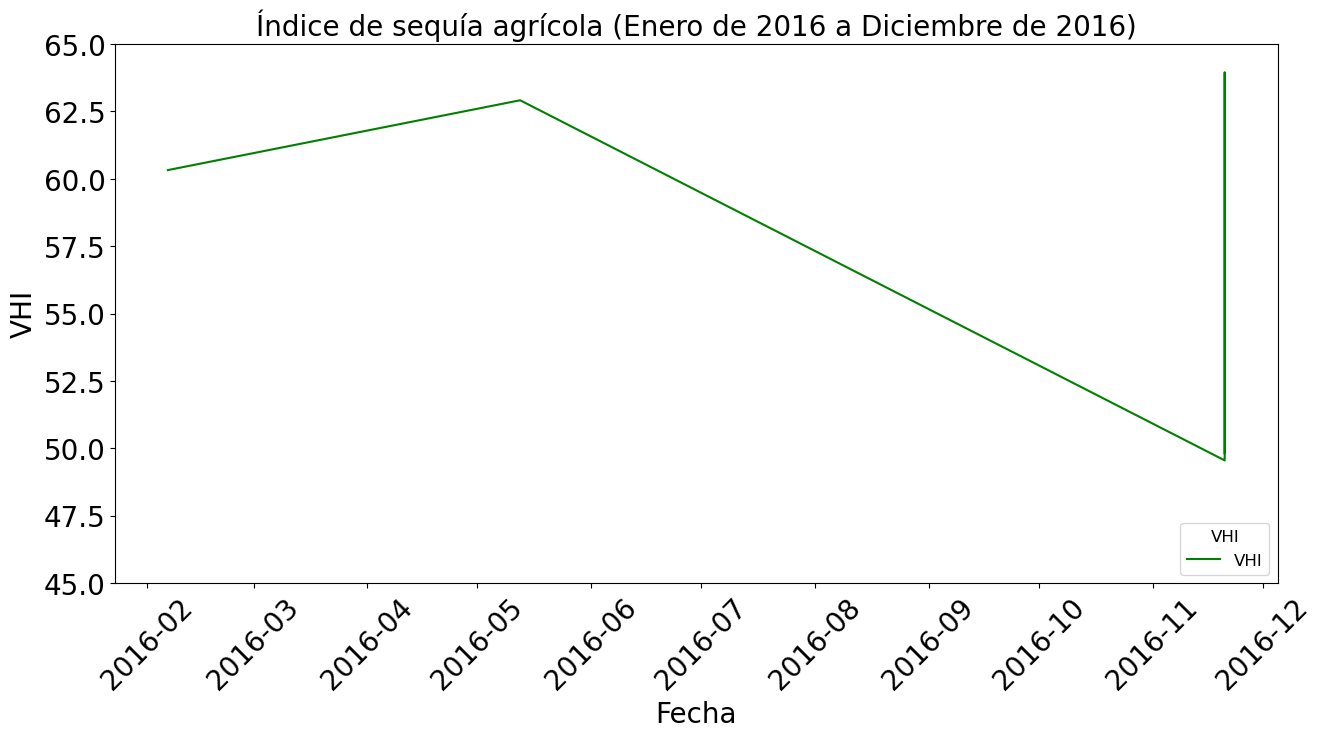

In [95]:
fig, ax = plt.subplots(figsize=(15,7))

sns.lineplot(data=df_VHIprom, ax=ax, palette =["g"], legend=False,label="VHI")

ax.legend(title="VHI",title_fontsize=12,fontsize=12, loc="lower right")
ax.tick_params(axis='both', which='major', labelsize=20) 
ax.set_ylabel('VHI',fontsize=20)
ax.set_xlabel('Fecha',fontsize=20)
ax.set_ylim((45,65))
ax.tick_params(axis="x", labelrotation=45)
ax.set_title('Índice de sequía agrícola (Enero de 2016 a Diciembre de 2016)',fontsize=20);